# Clustering and data visualisation
A common objective of biological data science is data exploration. Exploring data is useful if sample labels are unavailable or if we wish to assess data for confounding batch effects which are unrelated to biology. The sklearn library provides several tools for such unsupervised analysis. As representative of clustering, we will first apply the k-means approach. Besides selecting a method, the most important decision in clustering is specifying an appropriate number of clusters. We may to this end use metrics like the silhouette_score or the calinski_harabasz_score which are provided in sklearn.metrics to compare clusterings of data obtained with different cluster numbers. While these metrics provide additional guidance, model complexity metrics like AIC or BIC have an interpretation in terms of Occams razor. Giving rise to a proper model likelihood is a prerequisite for allowing to calculate such complexity metrics. Although k-means fails in this respect, the ml_lib propovides a score which we may regarded as a crude approximate of a log likelihood. 

## Fitting clustering methods
Methods like k-means, spectral clustering or Gaussian mixture models are highly nonlinear with many local optima. Allthough obtaining the global optimum is in general impossible, we must strive to obtain a solution which is at least reasonably similar to a global optimum. To obtain such solutions clustering methods are repeatedly started from randomly initialised parameters. The final solution is obtained iteratively, accepting a new local optimum only if its score outperforms the score of all previous runs. In particular for larger cluster numbers, we can not repeat model fitting often enough. 

## K-means with sklearn
The ml_lib.py provides a wrapper for the sklearn k-means approach which calculates the before mentioned crude approximate log likelihood in order to guide model selection by approximate AIC and BIC metrics. As we are really talking about crude approximations, we should also consider additional cluster validation methods like the silhouette_score or the calinski_harabasz_score.

## Data loading

In [1]:
## decide whether we run code in google colab amd access the google drive or 
## whether we run locally
incolab=True
if incolab:
    ## we mount the drive and set the basepath
    from google.colab import drive
    drive.mount('/content/drive')
    basepath="/content/drive/My Drive/exercise4colab.4students/"
else:
    ## we run locally and basepath is the parent directory 
    basepath="../"
### ml_lib.py resides in <basepath>/course.lib and contains course relevant
### library functions. To allw loading it we set a temporary path to
### the directory
import sys
sys.path.append(basepath+"course.lib/")
import ml_lib as mlib
## generic imports
import sklearn
import numpy as np
import pandas as pd
## We implement a classifier for selected GBM Affymetrix sample type
## specific genes. The data is quality checked, vsn transformed and ls
## normalised.
fnambase=basepath+"/course_data/GBM_AFFY_nrm_samplesel"
## set up an eset (synonymous to bioconductor esets)
gbmeset=mlib.PyEset()
## load the data using defaults (log 2 scale)
gbmeset.loadfromfile(fnambase)
## convert it to sklearn compatible data (split as input and target)
## The matrices which result from gbmeset.tolabeleddata(labelcol) match
## sklearn assumptions that rows are samples and columns are features.
labelcol="sample_type"
data4ml=gbmeset.tolabeleddata(labelcol)
y=data4ml["Y"] 
print(set(y))
## gbmeset has an item getter which allows for 
## indexing with boolean pandas series or
## vectors and lists. Since we want to cluster
## only the tumor samples, we extract those 
eset4clustering=gbmeset[:, y=="Primary Tumor"]
## Verhaak labels if known...
labelcol="verhaak.label"
data4ml=eset4clustering.tolabeleddata(labelcol)
X=data4ml["X"] 
y=data4ml["Y"] 
## X is your clustering input y provides some known GBM 
## subtypes (not all are known)

map2log
{'Solid Tissue Normal', 'Primary Tumor'}


## Using wrap_kmeans

In [2]:
from ml_lib import wrap_kmeans
from ml_lib import linmap
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
maxit=500          # iterations within a k-means fit
nrep=100           # number of repetions of k-means fitting for one k
njobs=-1           # paralleelisation
mink=2             # range of k
maxk=30
init='k-means++'   # parameter for sklearn k-means
# most happens inside wrap_kmeans!
res=wrap_kmeans(X, mink, maxk, nrep=nrep, njobs=njobs, init=init, maxit=maxit)

## Plot of complexity penalties

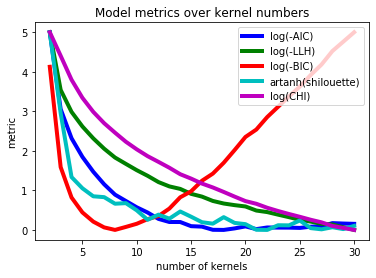

In [3]:
# plot cluster metrics
myfig=plt.figure()
plt.clf()
# all scores get transformed and mapped to the range 0-5
l1=plt.plot(res['allk'], linmap(np.log(-res['aics'])), 'b-', linewidth=4, 
            label='log(-AIC)')
l2=plt.plot(res['allk'], linmap(-res['llhs']), 'g-', linewidth=4, 
            label='log(-LLH)')
l3=plt.plot(res['allk'], linmap(np.log(-res['bics'])), 'r-', linewidth=4, 
            label='log(-BIC)')
l4=plt.plot(res['allk'], linmap(np.arctanh(res['shlts'])), 'c-', linewidth=4, 
            label='artanh(shilouette)')
l5=plt.plot(res['allk'], linmap(np.log(res['chinds'])), 'm-', linewidth=4, 
            label='log(CHI)')
plt.ylabel('metric')
plt.xlabel('number of kernels')
plt.title('Model metrics over kernel numbers')
plt.legend(loc=1)
plt.show()
with PdfPages(basepath+'resfigs/GBM_patient_clusters_aic_bic.pdf') as pdf:
    pdf.savefig(myfig)

## Interpreting cluster number metrics

The approximate BIC suggests that six clusters are optimal. This is twice the number of the GBM subtypes that were proposed by the analysis of Verhaak et al. in 2010. The above plot replicates a usual finding with AIC based model selection, namely the tendency of AIC to overestimate model complexity for large sample sizes. The difficulty of selecting an optimum is apparent from the fact that both silhouette and Calinski Harabasz scores are optiumal for 2 clusters. The Verhaak proposition of 4 GBM subtypes is thus in the range of clusters predicted by the k-means approach.

## Visualising BIC optimal clusters with a two dimensional PCA projection

Allthough PCA is in terms of number of applications a bit overrated as projection, it is numerically simple to obtain and thus our first visualisation approach. We propose to this end to apply sklearn.decomposition.PCA with 2 components to the gene expression matrix X and visualise the projected expression vectiors together with the projected k-means cluster centers.

(8, 501)


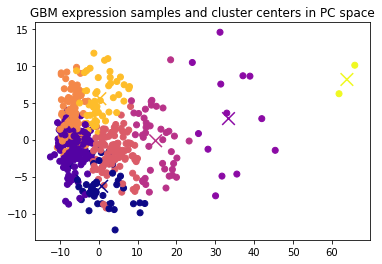

In [10]:
## This is your turn again: provide a visualisation of the 
## gene expression data X and the BIC optimal cluster centers 
## using a PCA projection.
## 
## the optimal BIC model is obtained as follows
bic_opt_mdl=res['bicpars'][0]
opt_centers=bic_opt_mdl.cluster_centers_
print(opt_centers.shape) ## should be (8 x 501)
## HINT: sklearn provides PCA by instantiating 
## sklearn.decomposition.PCA


## tSNE : an advanced ML approach for visualising data

While PCA is quick, the projections are based on a simple 
coordinate rotation under the assumption that X is drawn from a 
multivariate Gaussian. In many situations improved visualisations
are obtained by advanced methods like tSNE. It should however be
kept in mind that tSNE is a nonlinear approach which converges to
local optima. Parameter estimation should thus keep track of the overall 
optimum and repeat model fitting from random initialisations.

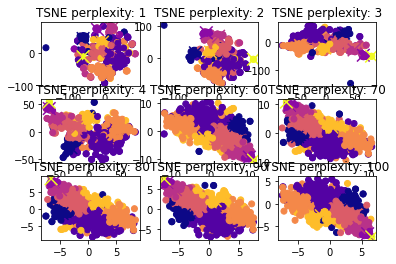

In [7]:
## Hint: tSNE is available in sklearn as sklearn.manifold.TSNE
## Model fitting has to vary perplexity. For every perplexity 
## we should select a model with a reasonable good score by 
## iterating over as many optimisations as we can afford.
from sklearn.manifold import TSNE

## 1) we will now transform the data to a TSNE representation. The
## proposition in high dimensional situations is to project the entire
## data first to PCA space (e.g. 100 dimensions) and subsequently apply TSNE 

## 2) fit tSNE on a matrx which combines data and kernel centers simultaneously. 
## (tSNE is a non parametric approach which has no underlying model)

## 3) plot the data for different perplexities in several subplots
## For visualisation separate them afterwards and plot kernel centers and samples 
## allocated to the kernel in the same colour.


## Spectral clustering
Experiment yourself with spectral clustering. Provide a quantitative assesment of similarities and differences in comparison with k-means clustering.

In [ ]:
## Hint: look at sklearn.cluster.SpectralClustering 
## Your solution should also try to reason about how 
## to determine the number of cluster centers in this case.
## A technique called "consensus clustering" provides a 
## simulation based approach which works independently of metrics. 

## Discussion
Provide a discussion of your findings. Compare the results obtauned with k-means and spectral clustering. Which visualisation provides better results PCA or tSNE? 